In [4]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, rlm

from patsy import dmatrices
from sklearn_pandas import DataFrameMapper, cross_val_score
import sklearn.preprocessing, sklearn.decomposition, sklearn.linear_model, sklearn.pipeline, sklearn.metrics

In [5]:
data = pd.read_csv(
    "directed_unlimited/unmodified_symbol_and_name_in_subject_with_[ANN]_first_thread_post_introducers_metrics.csv", 
    index_col='coin').join(pd.read_csv(
        'types.csv',index_col='coin')).join(pd.read_csv(
        'coinmarketanalisis.csv',index_col='coin',skipinitialspace=True))
data['user1_years_since_first_post'] = data.user1_days_since_first_post/365.
data['log_severity']=np.log(data['severity_to_average_after_max_volume_weighted'])
data['log_volume']=np.log(data['total_volume'])

#subselect the variables we will be using inthe analysis    
tight_dataset = data[['user1_num_posts',
                      'user1_years_since_first_post',
                      'user1_clustering_coefficient',
                      'user1_closeness_centrality_unweighted',
                      'user1_satoshi_pagerank_weighted',
                      'type',
                      'log_volume',
                      'log_severity']]
independent_vars = " user1_num_posts + user1_years_since_first_post + user1_clustering_coefficient + user1_closeness_centrality_unweighted + user1_satoshi_pagerank_weighted + type"

In [6]:
print ols(formula="np.log(total_volume) ~ " + independent_vars ,data=data).fit(cov_type='HC3').summary() 

                             OLS Regression Results                             
Dep. Variable:     np.log(total_volume)   R-squared:                       0.124
Model:                              OLS   Adj. R-squared:                  0.105
Method:                   Least Squares   F-statistic:                     3.907
Date:                  Wed, 14 Oct 2015   Prob (F-statistic):           0.000922
Time:                          02:37:56   Log-Likelihood:                -637.45
No. Observations:                   279   AIC:                             1289.
Df Residuals:                       272   BIC:                             1314.
Df Model:                             6                                         
Covariance Type:                    HC3                                         
                                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------

In [7]:
print ols(formula="np.log(total_volume) ~ user1_num_posts:type + user1_years_since_first_post:type + type + user1_closeness_centrality_unweighted:type ",data=data).fit(cov_type='HC3').summary() 

                             OLS Regression Results                             
Dep. Variable:     np.log(total_volume)   R-squared:                       0.126
Model:                              OLS   Adj. R-squared:                  0.103
Method:                   Least Squares   F-statistic:                     3.789
Date:                  Wed, 14 Oct 2015   Prob (F-statistic):           0.000610
Time:                          02:37:56   Log-Likelihood:                -637.19
No. Observations:                   279   AIC:                             1290.
Df Residuals:                       271   BIC:                             1319.
Df Model:                             7                                         
Covariance Type:                    HC3                                         
                                                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------

In [8]:
print ols(formula="np.log(severity_to_average_after_max_volume_weighted) ~ user1_num_posts + user1_years_since_first_post + type + user1_closeness_centrality_unweighted:type ",data=data).fit(cov="H0").summary() 

                                              OLS Regression Results                                             
Dep. Variable:     np.log(severity_to_average_after_max_volume_weighted)   R-squared:                       0.097
Model:                                                               OLS   Adj. R-squared:                  0.081
Method:                                                    Least Squares   F-statistic:                     5.893
Date:                                                   Wed, 14 Oct 2015   Prob (F-statistic):           3.43e-05
Time:                                                           02:37:57   Log-Likelihood:                -248.56
No. Observations:                                                    279   AIC:                             509.1
Df Residuals:                                                        273   BIC:                             530.9
Df Model:                                                              5                

In [9]:
print ols(formula="np.log(severity_to_average_after_max_volume_weighted) ~ " + independent_vars,data=data).fit(cov="H0").summary() 

                                              OLS Regression Results                                             
Dep. Variable:     np.log(severity_to_average_after_max_volume_weighted)   R-squared:                       0.104
Model:                                                               OLS   Adj. R-squared:                  0.084
Method:                                                    Least Squares   F-statistic:                     5.268
Date:                                                   Wed, 14 Oct 2015   Prob (F-statistic):           3.73e-05
Time:                                                           02:37:59   Log-Likelihood:                -247.52
No. Observations:                                                    279   AIC:                             509.0
Df Residuals:                                                        272   BIC:                             534.5
Df Model:                                                              6                

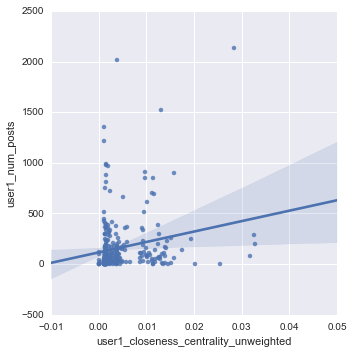

In [10]:
sns.lmplot('user1_closeness_centrality_unweighted','user1_num_posts',data)

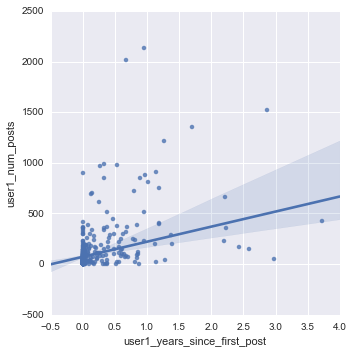

In [192]:
sns.lmplot('user1_years_since_first_post','user1_num_posts',data,robust=True)

In [220]:
data.columns

Index([u'earliest_trade_date', u'network_date', u'user1',
       u'user1_num_mentions', u'user1_num_posts', u'user1_num_subjects',
       u'user1_days_since_first_post', u'user1_degree_total',
       u'user1_degree_incoming', u'user1_degree_outgoing',
       u'user1_clustering_coefficient',
       u'user1_closeness_centrality_unweighted',
       u'user1_closeness_centrality_weighted',
       u'user1_closeness_centrality_incoming_unweighted',
       u'user1_closeness_centrality_outgoing_unweighted',
       u'user1_closeness_centrality_incoming_weighted',
       u'user1_closeness_centrality_outgoing_weighted',
       u'user1_betweenness_centrality_weighted', u'user1_satoshi_distance',
       u'user1_satoshi_pagerank_weighted', u'user1_pagerank_weighted', u'name',
       u'type', u'subcategory', u'max_price', u'min_price',
       u'severity_to_min_price', u'severity_to_min_price_after_max',
       u'severity_to_last', u'severity_to_average',
       u'severity_to_average_after_max',
      

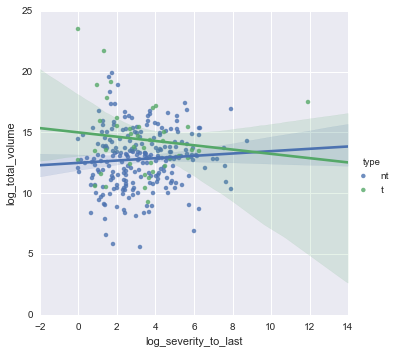

In [117]:
sns.lmplot("log_severity", "log_volume",data,hue='type')

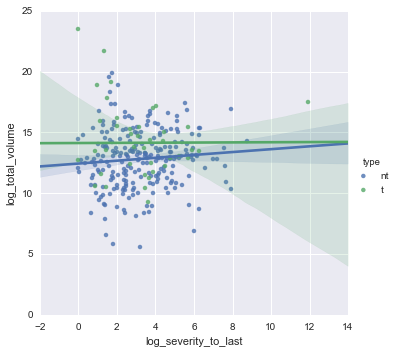

In [131]:
sns.lmplot("log_severity_to_last", "log_total_volume",data,hue='type', robust=True)

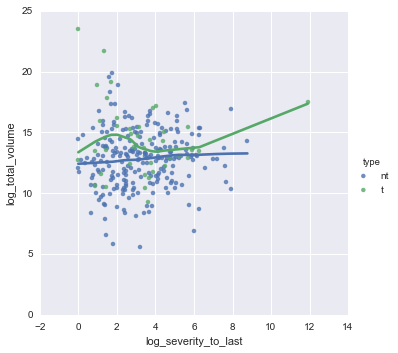

In [132]:
sns.lmplot("log_severity_to_last", "log_total_volume",data,hue='type', lowess=True)

' user1_num_posts + user1_years_since_first_post + user1_clustering_coefficient + user1_closeness_centrality_unweighted + user1_satoshi_pagerank_weighted + type'

In [185]:

y,X = dmatrices("np.log(total_volume) ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['np.log(total_volume)'])
#model_aic = LassoLarsIC(criterion='aic')
#model_aic.fit(np.array(X), np.array(y))
print sm.OLS(y,X).fit(cov_type='HC3').summary() 

reg_para = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]

from sklearn.linear_model import Lasso, LassoCV
lasso_model = LassoCV(cv=10, alphas=reg_para)
lasso_fit = lasso_model.fit(X,y)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                 4.381e+15
Date:                Wed, 14 Oct 2015   Prob (F-statistic):               0.00
Time:                        01:51:57   Log-Likelihood:                -377.36
No. Observations:                 279   AIC:                             766.7
Df Residuals:                     273   BIC:                             788.5
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.1064      0.033     -3.191      0.0

Average out of sample score on cross validation 0.054735


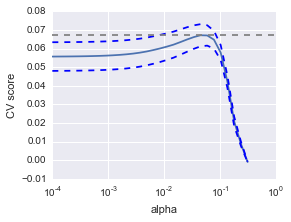

In [228]:
from sklearn import cross_validation, linear_model
import matplotlib.pyplot as plt
y,X = dmatrices("log_severity ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_severity'])

lasso = linear_model.Lasso()
alphas = np.logspace(-4, -.5, 30)

scores = list()
scores_std = list()

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_validation.cross_val_score(lasso, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

plt.figure(figsize=(4, 3))
plt.semilogx(alphas, scores)
# plot error lines showing +/- std. errors of the scores
plt.semilogx(alphas, np.array(scores) + np.array(scores_std) / np.sqrt(len(X)),
             'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std) / np.sqrt(len(X)),
             'b--')
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')


lasso_cv = linear_model.LassoCV(alphas=alphas)
k_fold = cross_validation.KFold(len(X), 5)
scores=[]
for k, (train, test) in enumerate(k_fold):
    lasso_cv.fit(X[train], y[train])
    s=lasso_cv.score(X[test], y[test])
    scores.append(s)
print "Average out of sample score on cross validation %f"% np.average(scores)


Average out of sample score on cross validation 0.058798


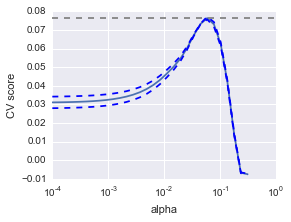

In [229]:
from sklearn import cross_validation, linear_model
import matplotlib.pyplot as plt
y,X = dmatrices("log_volume ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_volume'])

lasso = linear_model.Lasso()
alphas = np.logspace(-4, -.5, 30)

scores = list()
scores_std = list()

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_validation.cross_val_score(lasso, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

plt.figure(figsize=(4, 3))
plt.semilogx(alphas, scores)
# plot error lines showing +/- std. errors of the scores
plt.semilogx(alphas, np.array(scores) + np.array(scores_std) / np.sqrt(len(X)),
             'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std) / np.sqrt(len(X)),
             'b--')
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')


lasso_cv = linear_model.LassoCV(alphas=alphas)
k_fold = cross_validation.KFold(len(X), 5)
scores=[]
for k, (train, test) in enumerate(k_fold):
    lasso_cv.fit(X[train], y[train])
    s=lasso_cv.score(X[test], y[test])
    scores.append(s)
print "Average out of sample score on cross validation %f"% np.average(scores)


In [41]:
from sklearn.grid_search import  RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

clf = RandomForestRegressor(n_estimators=20)
y,X = dmatrices("log_volume ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_volume'])



# specify parameters and distributions to sample from
param_dist = {"max_depth": [2, None],
              "max_features": sp_randint(1, len(X[1])),
              "min_samples_split": sp_randint(1, len(X[1])),
              "min_samples_leaf": sp_randint(1, len(independent_vars)),
              "bootstrap": [True, False]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

RandomizedSearchCV took 0.78 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.048 (std: 0.005)
Parameters: {'max_features': 2, 'min_samples_split': 2, 'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 22}

Model with rank: 2
Mean validation score: 0.037 (std: 0.011)
Parameters: {'max_features': 4, 'min_samples_split': 2, 'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 46}

Model with rank: 3
Mean validation score: 0.028 (std: 0.029)
Parameters: {'max_features': 5, 'min_samples_split': 4, 'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 9}



In [43]:
from sklearn.grid_search import  RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

clf = RandomForestRegressor(n_estimators=20)
y,X = dmatrices("log_severity ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_severity'])



# specify parameters and distributions to sample from
param_dist = {"max_depth": [2, None],
              "max_features": sp_randint(1, len(X[1])),
              "min_samples_split": sp_randint(1, len(X[1])),
              "min_samples_leaf": sp_randint(1, len(independent_vars)),
              "bootstrap": [True, False]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

RandomizedSearchCV took 0.97 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.098 (std: 0.059)
Parameters: {'max_features': 4, 'min_samples_split': 2, 'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 50}

Model with rank: 2
Mean validation score: 0.096 (std: 0.067)
Parameters: {'max_features': 3, 'min_samples_split': 1, 'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 39}

Model with rank: 3
Mean validation score: 0.083 (std: 0.122)
Parameters: {'max_features': 4, 'min_samples_split': 2, 'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5}



In [58]:




from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

###############################################################################
y,X = dmatrices("log_severity ~ 0+  " + independent_vars ,data,return_type='dataframe' )
feature_names = X.columns
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_severity'])
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

###############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.001, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)


# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
print gs_cv.best_params_


###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

###############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

MSE: 0.8021


NameError: name 'est' is not defined

In [53]:
from sklearn import datasets
y,X = dmatrices("log_severity ~ 0+  " + independent_vars ,data,return_type='dataframe' )

boston = datasets.load_boston()
boston.feature_names[sorted_idx]


Index([u'type[nt]', u'type[t]', u'user1_years_since_first_post',
       u'user1_satoshi_pagerank_weighted', u'user1_num_posts',
       u'user1_clustering_coefficient',
       u'user1_closeness_centrality_unweighted'],
      dtype='object')

Automatically created module for IPython interactive environment
________________________________________________________________________________
Training GBRT...
done.
________________________________________________________________________________
Convenience plot with ``partial_dependence_plots``

________________________________________________________________________________
Custom 3d plot via ``partial_dependence``



IndexError: tuple index out of range

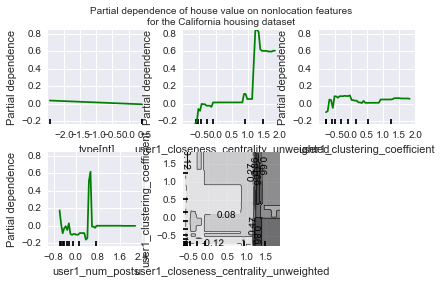

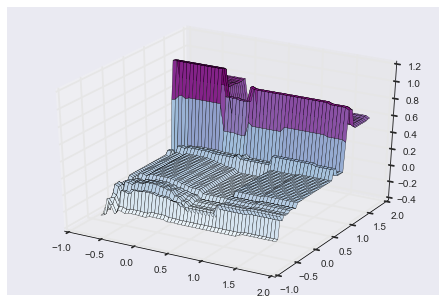

In [64]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.datasets.california_housing import fetch_california_housing



y,X = dmatrices("log_severity ~ 0+  " + independent_vars ,data,return_type='dataframe' )
names = X.columns
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_severity'])
offset = int(X.shape[0] * 0.8)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# split 80/20 train-test

print('_' * 80)
print("Training GBRT...")
clf = GradientBoostingRegressor(n_estimators=100, max_depth=6,
                                learning_rate=0.01, loss='ls',
                                random_state=1)
clf.fit(X_train, y_train)
print("done.")

print('_' * 80)
print('Convenience plot with ``partial_dependence_plots``')
print

features = [0, 5, 4, 2, (5, 4)]
fig, axs = plot_partial_dependence(clf, X_train, features, feature_names=names,
                                   n_jobs=3, grid_resolution=50)
fig.suptitle('Partial dependence of house value on nonlocation features\n'
             'for the California housing dataset')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

print('_' * 80)
print('Custom 3d plot via ``partial_dependence``')
print
fig = plt.figure()

target_feature = (4, 5)
pdp, (x_axis, y_axis) = partial_dependence(clf, target_feature,
                                           X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(names[target_feature[4]])
ax.set_ylabel(names[target_feature[5]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of house value on median age and '
            'average occupancy')
plt.subplots_adjust(top=0.9)

plt.show()

In [24]:
X[1]

array([ 0.40910147, -0.40910147,  0.01537515,  4.12847359,  0.05030473,
        0.03079631, -0.14341801])

In [62]:
y,X = dmatrices("log_severity ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X.columns

Index([u'type[nt]', u'type[t]', u'user1_num_posts',
       u'user1_years_since_first_post', u'user1_clustering_coefficient',
       u'user1_closeness_centrality_unweighted',
       u'user1_satoshi_pagerank_weighted'],
      dtype='object')

In [43]:
"np.log(total_volume) " + independent_vars

'np.log(total_volume)  ~ user1_num_posts + user1_years_since_first_post + user1_clustering_coefficient + user1_closeness_centrality_unweighted + user1_satoshi_pagerank_weighted + type'

In [99]:
data.values

array([['2014-08-27', '2014-08-15', 'Project Axron', ..., False,
        0.0027397260273972603, 2.4932736279398613],
       ['2014-02-09', '2013-12-22', 'myhoho', ..., False,
        2.4356164383561643, 4.264240618973683],
       ['2013-05-22', '2013-05-15', 'WorldCoin', ..., False,
        0.0027397260273972603, 3.6982008854492725],
       ..., 
       ['2014-07-10', '2014-06-22', 'mitchellmint', ..., True,
        0.3232876712328767, 1.5841451197717964],
       ['2014-05-26', '2013-05-16', 'Supercoin', ..., False,
        0.0027397260273972603, 4.54434111357337],
       ['2014-02-10', '2014-01-23', 'SCryptoMiners', ..., True,
        0.00821917808219178, 2.4707768956905363]], dtype=object)

In [151]:
data['user1_num_mentions'].describe()

count    315
mean       1
std        0
min        1
25%        1
50%        1
75%        1
max        1
Name: user1_num_mentions, dtype: float64

In [60]:
X.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15fefcfd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a351a650>]], dtype=object)

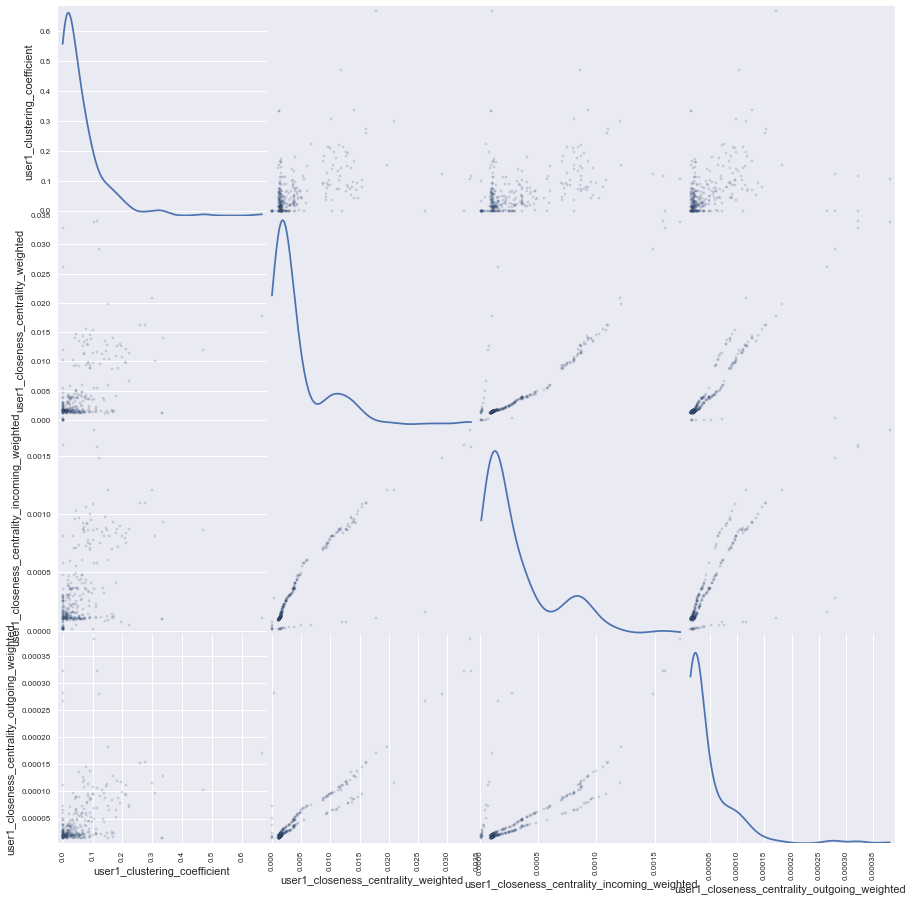

In [221]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(data[[
       u'user1_clustering_coefficient',
       u'user1_closeness_centrality_weighted',
       u'user1_closeness_centrality_incoming_weighted',
       u'user1_closeness_centrality_outgoing_weighted']], alpha=0.2, figsize=(15, 15), diagonal='kde')

